<center>
<img src="https://i.vas3k.blog/7sc.jpg" height="400">

# Семинар 2: Свертка изображений
</center>

На ближайших семинарах мы научимся решать некоторые задачи компьютерного зрения при помощи нейронных сетей. Основной инструмент работы в этой области — свёртки. С ними мы сегодня и познакомимся.

### План семинара

1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**
2. Применяем константные свёртки к изображениям
3. Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST


In [1]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

# 1. Разбираемся что такое картинка



In [2]:
# при работе в колабе, скачайте изображение этой командой
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

--2025-09-17 20:40:47--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73801 (72K) [image/jpeg]
Saving to: ‘butterfly.jpg.2’

butterfly.jpg.2     100%[===================>]  72.07K  --.-KB/s    in 0.001s  

2025-09-17 20:40:47 (58.2 MB/s) - ‘butterfly.jpg.2’ saved [73801/73801]



Image format: JPEG; shape: (640, 427); color scheme: RGB


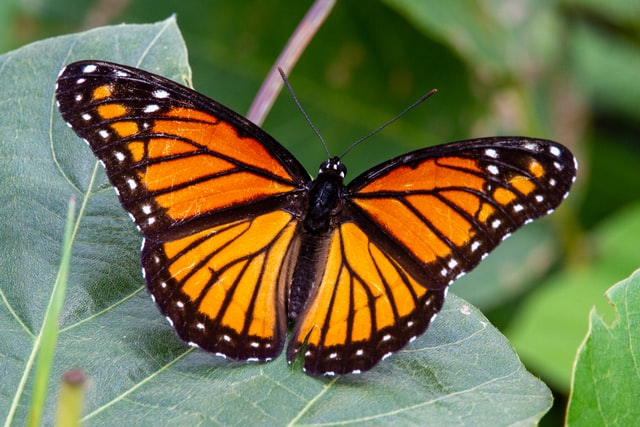

In [3]:
# !pip install Pillow
from PIL import Image

img = Image.open("./butterfly.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

## Матричное представление изображения

На самом деле каждая картинка это набор пикселей. Если мы попросим питон показать нам картинку, он покажет матрицу из чисел.  Каждому пикселю в этой матрице соответствует число. Это число сообщает нам о том, насколько этот пиксель яркий. Яркость можно измерять в разных шкалах. В нашем случае она измеряется по шкале от $0$ до $1$.

Цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему. Такой формат хранения картинки называется [RGB-форматом.](https://www.wikiwand.com/ru/RGB)

Image array shape: (427, 640, 3)


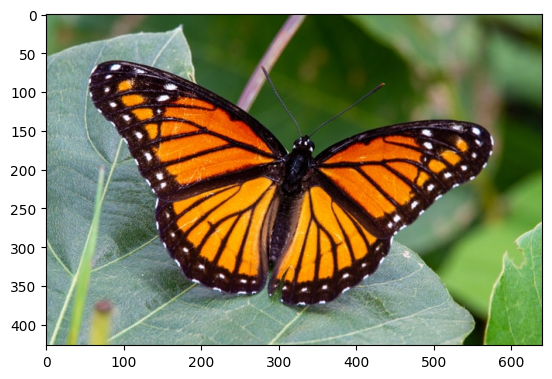

In [4]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image array shape: {img_matrix.shape}")

plt.imshow(img_matrix);

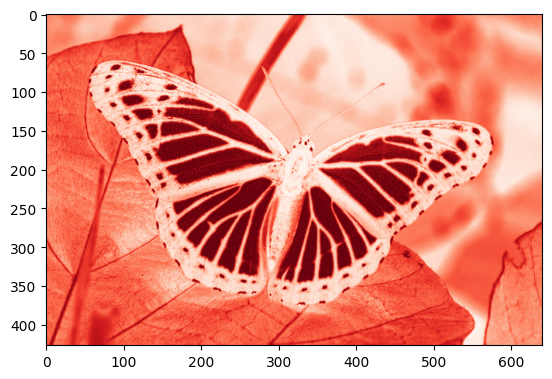

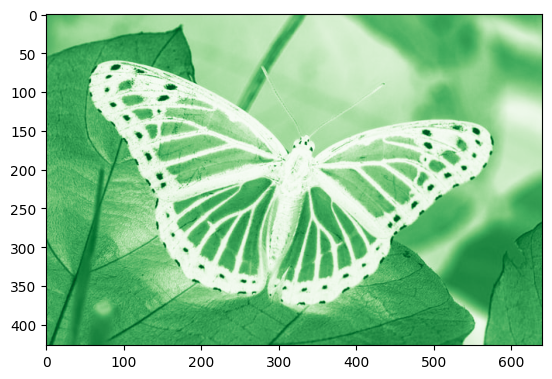

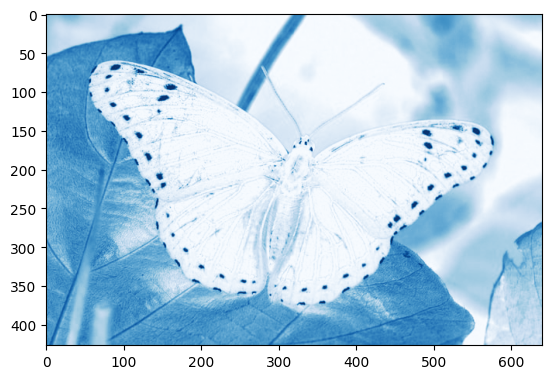

In [5]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

Все действия по редактированию картинки сводятся к математике. Например, чтобы осветлить картинку, нужно прибавить к каждому пикселю какое-то число. Часто такие математические действия над картинками записывают в виде операции свёртки. Свёртка принимает на вход одну картинку, а на выход отдаёт новую, переработанную.

# 2. Пробуем применить свёртки к картинке

**Необязательное задание:** один из семенирстов собрал [коллекцию ручных задачек на свёртки.](https://fulyankin.github.io/deep_learning_masha_book/problem_set_05_conv/problem_01.html) Чтобы лучше почувствовать, как работают разные части свёрточных сеток, можно попробовать порешать эти задачки. К каждой из них на страничке есть решение.

### Класс torch.nn.Conv2d

In [6]:
import torch.nn as nn

nn.Conv2d

torch.nn.modules.conv.Conv2d

В **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- `in_channels`: количество входных каналов
- `out_channels`: количество выходных каналов
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

#### `kernel_size`

**Размер ядра**. `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**`kernel_size=3`**

![no_padding_no_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic).

#### `stride`

**Шаг**. Задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**`stride=2`**

![no_padding_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_strides.gif)

#### `padding`

**Паддинг**. Количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**`padding=1`**

![same_padding_no_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/same_padding_no_strides.gif)

### Класс MaxPool2d

In [7]:
import torch.nn as nn

nn.MaxPool2d

torch.nn.modules.pooling.MaxPool2d

В **PyTorch** уменьшает размерность, сохраняя наиболее «выразительные» признаки (максимумы), представлен в модуле `torch.nn` классом [`MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) с параметрами:
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг (по умолчанию 0)
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

![MaxPooling.png](https://media.geeksforgeeks.org/wp-content/uploads/Screenshot-from-2017-08-15-17-04-02.png)

Изображение взято [здесь](https://www.geeksforgeeks.org/computer-vision/apply-a-2d-max-pooling-in-pytorch/).

### Класс Flatten

В **PyTorch** операция выпрямления (преобразования многомерного тензора в вектор) представлена в модуле torch.nn классом [`Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

In [8]:
import torch.nn as nn

nn.Flatten

torch.nn.modules.flatten.Flatten

![Flatten.png](https://raw.githubusercontent.com/hse-ds/iad-deep-learning/refs/heads/master/2024/seminars/02.%20Image%20Convolution/static/Flatten.png)

## Свёртка изображений

Чем может быть полезна свертка при работе с изображениями? Свертки детектируют **паттерны на картинках** – цвета и сочетания цветов, небольшие объекты. Обычно значения свертки являются обучаемыми параметрами нейрости. Однако существуют "готовые" свертки, настроенные на определенные паттерны.

Например, оператор Собеля (свертка с определенными параметрами) используется для детекции границ на изображении. Применим этот оператор. Для этого пока не будем пользоваться классом `torch.nn.Conv2d`, а возьмём соответствующую функцию из модуля `torch.nn.functional`.

In [9]:
import torch

# В этом модуле примерно все те же самые операторы, что и в `torch.nn`,
# но только представлениы они не в виде классов, а виде функций.
from torch.nn.functional import conv2d

Конвертируем изображение в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [10]:
img_matrix.shape

(427, 640, 3)

In [11]:
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [12]:
sobel_hor = [
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
]

# одна матрица на каждый канал картинки
kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [13]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 425, 638, 1])

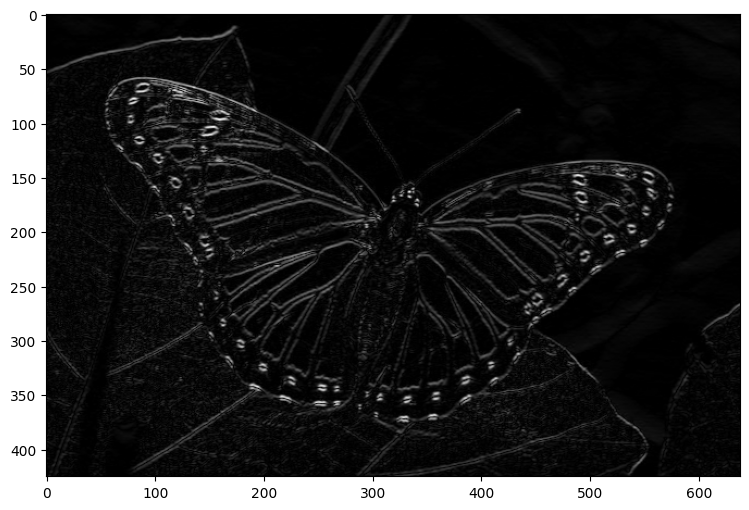

In [14]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]), cmap='gray');

Проделаем то же самое для детектирования вертикальных границ

In [15]:
sobel_ver = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]

# одна матрица на каждый канал картинки
kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 425, 638, 1])

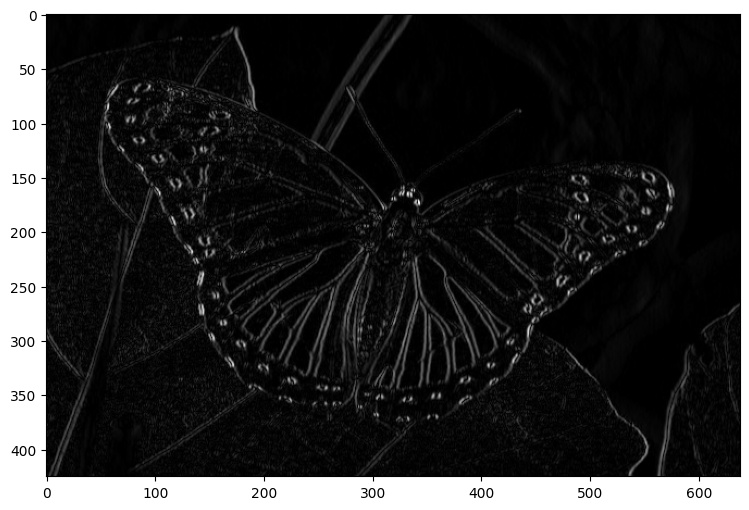

In [16]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]), cmap='gray');

Объединим два изображения

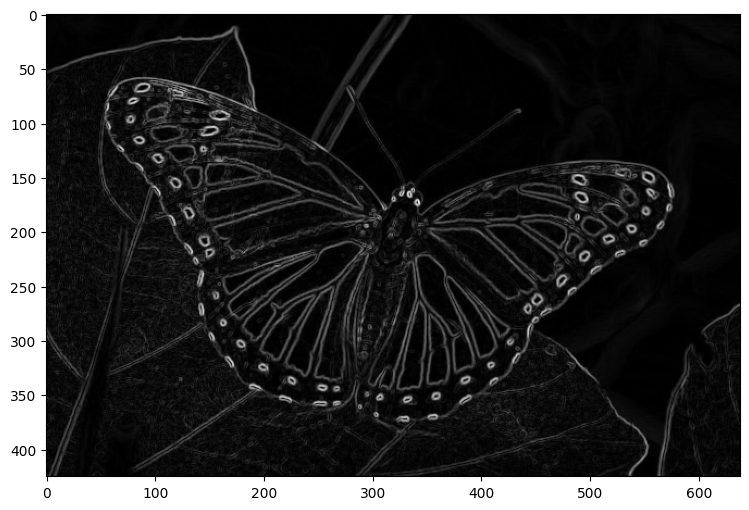

In [17]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0], cmap='gray');

### Задание 1

По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

In [18]:
# your code here
# =^･ｪ･^=

img_conv_random = ...

# рисуем результат
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_random[0, :, :, 0]), cmap='gray');

# 3. Обучаем полносвязную нейросеть

Попробуем обучить полносвязную нейросеть для классификации картинок. Мы уже делали подобную штуку на первом семинаре, поэтому просто вспомним все необходимые нам для этого кусочки.


In [19]:
import torch
import torchvision

import torch.nn.functional as F
from torch import nn

from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


Для начала подгрузим данные.

In [20]:
transform = torchvision.transforms.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,)), # Как думаете, что это за числа и откуда их взяли?
])

Для того, чтобы нейронка корректно обучалась картинки обычно нормализуют на отезок $[-1,1]$. Такая нормализация довольно сильно ускоряет алгоритм обратного распространения ошибки, так как градиенты в рамках одного слоя могут оказываться разных знаков.

In [21]:
train_set = MNIST('.MNIST', transform=transform, train=True, download=True)
val_set = MNIST('.MNIST', transform=transform, train=False, download=True)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size     = 256,
    shuffle        = True,
    num_workers    = 0
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size    = 4096,
    shuffle       = False,
    num_workers   = 0
)

Подготовим функции для обучения. WandB как иснструмент для логгирования результатов тут вынесен в отдельную опцию, чтобы им можно было пользоваться только при желании.

In [44]:
# !pip install wandb -qU

In [45]:
# import wandb
# wandb.login()

In [22]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [23]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc, wandb_project=None):
    """Одна эпоха обучения"""
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if wandb_project:
            metrics = {
                "batch-train/loss": loss.item()
            }
            wandb.log(metrics)

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    """Прогнозы на валидации"""

    val_loss, val_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    return val_loss, val_accuracy


def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None, wandb_project=None):
    """Обучение модели"""
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # подключаем wandb
    if wandb_project:
        wandb.init(project=wandb_project)
        wandb.watch(model)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}',
            wandb_project=wandb_project
        )
        val_loss, val_accuracy = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # функция для смены lr по расписанию
        if scheduler is not None:
            scheduler.step()

        if wandb_project:
            metrics = {
                "train/loss": train_loss / len(train_loader.dataset),
                "train/accuracy": train_accuracy / len(train_loader.dataset),
                "val/loss": val_loss,
                "val/accuracy": val_accuracy
            }
            wandb.log(metrics)
        else:
          plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

    # печатаем метрики
    print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

### Задание 2

Соберите полносвязную сеть из 3 слоёв с $32$, $16$, и $10$ нейронами. На всех промежуточных слоях используйте `ReLU` в качестве функции активации. Последний слой должен возвращать логиты для дальнейшей классификации.

In [ ]:
class FcNet(nn.Module):
    def __init__(self, input_shape, hide_neurons=32, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            # your code here
            # =^･ｪ･^=
            nn.Flatten(),                                # превращаем картинку 28х28 в вектор размером 784
            nn.Linear(input_shape, hide_neurons),        # линейный слой, преобразующий вектор размера 784 в вектор размера 32
            nn.ReLU(),                                   # нелинейность
            nn.Linear(hide_neurons, hide_neurons // 2),  # линейный слой, преобразующий вектор размера 784 в вектор размера 16
            nn.ReLU(),                                   # нелинейность
            nn.Linear(hide_neurons//2, num_classes),     # линейный слой, преобразующий вектор размера 784 в вектор размера 10
        )

    def forward(self, x):
        return self.model(x)

In [25]:
IMG_SIZE = 28
NUM_EPOCH = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_fc = FcNet(IMG_SIZE**2).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_fc.parameters(), lr=0.01, momentum=0)

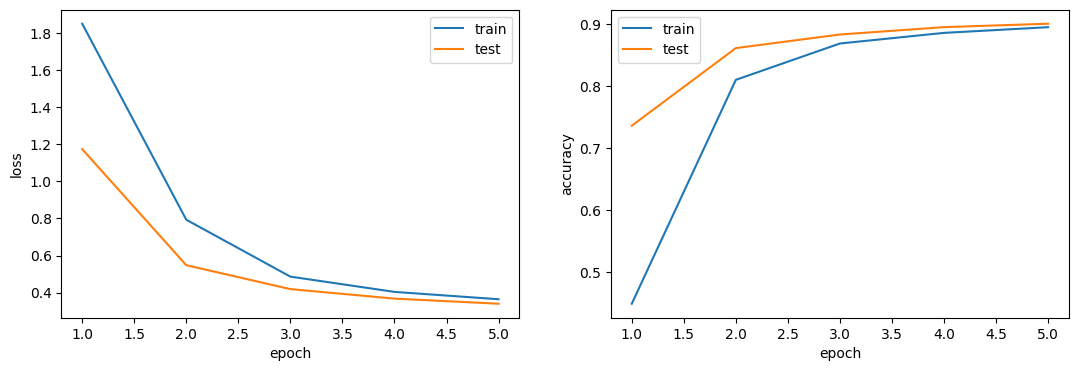

Epoch: 5, loss: 0.34044941351413727, accuracy: 0.9


In [26]:
train(model_fc, optimizer, criterion, train_loader, val_loader, NUM_EPOCH)

__Вопроc:__ сколько параметров вы обучили в получившейся нейронной сети? Почему использовать полносвязные сети для классификации картинок не самая лучшая идея?

Давайте попробуем построить предсказания на валидационной выборке и посмотрим, на примеры картинок, где модель ошиблась. Иногда бывает полезно отсматривать конкретные примеры ошибок, чтобы подумать как можно улучшить модель.

### Задание 3

Если вы запустите функцию ниже, она упадёт и не будет работать. Исправьте ошибку и объясните, откуда она возникает.

In [27]:
# fix me please  =^･ｪ･^=
# забыли отправить на .cpu() данные

def predict(model, val_loader):
    X, y, logit = [], [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        X.extend(x_batch)
        y.extend(y_batch)
        x_batch = x_batch.to(device)

        with torch.no_grad():
            logits = model(x_batch)

        logit.extend(torch.max(logits, 1)[1].cpu().numpy())
    return np.array(X), np.array(y), np.array(logit)

In [28]:
X_test, y_test, y_pred = predict(model_fc, val_loader)

In [29]:
errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

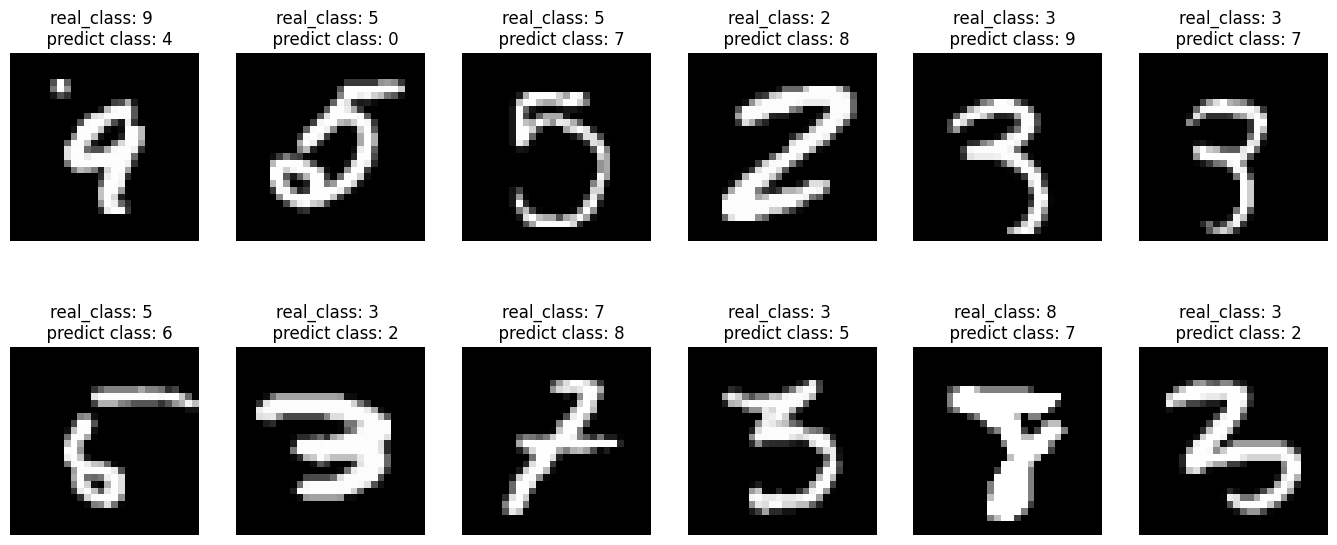

In [30]:
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

Посмотрим на то, путает ли модель систематически одни классы с другими. Чтобы лучше было видно занулим диагональ у `confusion_matrix`.

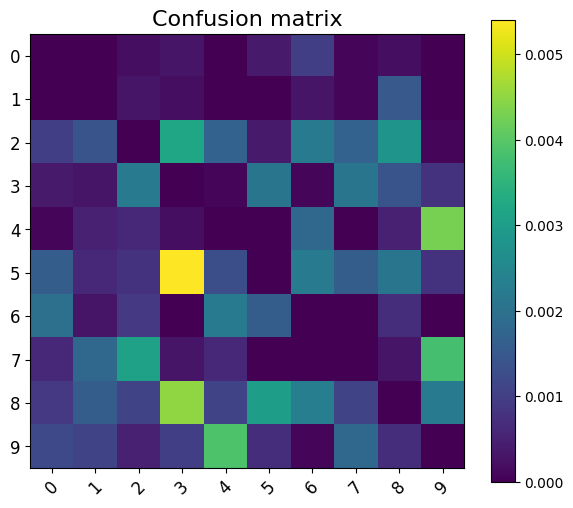

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred, normalize='all')
cm = cm - np.eye(10)*cm.diagonal()

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(cm)
plt.xticks(np.arange(10), np.arange(10), rotation=45, fontsize=12)
plt.yticks(np.arange(10), np.arange(10), fontsize=12)
plt.colorbar();

# 4. Обучаем свёрточную нейронную сеть

### Задание 3

По аналогии с предыдущим примером, обучите свёрточную нейронную сеть. В части `encoder` задайте следующие слои:

- Свёрточный слой с 2 ядрами размером 3
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 4 ядрами размером 3
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 8 ядрами размером 3
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)

В части `classifier` задайте следующие слои:

- Полносвязный слой с 32 нейронами (аккуратно осознайте сколько нейронов будет на входе и почему)
- Функция активации ReLU
- Выходной слой с 10 нейронами

In [47]:
class ConvNet(nn.Module):

    def __init__(self, image_channels=1):
        super().__init__()

        self.encoder = nn.Sequential(  # 28 x 28
            # your code here
            # =^･ｪ･^=
            nn.Conv2d(in_channels=image_channels, out_channels=4,
                      kernel_size=3, padding='same'),  # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 x 14

            nn.Conv2d(in_channels=4, out_channels=8,
                      kernel_size=3, padding='same'),  # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7 x 7

            nn.Conv2d(in_channels=8, out_channels=16,
                      kernel_size=3, padding='same'),  # 7 x 7
            nn.ReLU(),
            nn.MaxPool2d(2)  # 3 x 3
        )

        self.head = nn.Sequential(
            # your code here
            # =^･ｪ･^=
            nn.Linear(in_features=144, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, x):

        # x: B x 1 x 28 x 28
        out = self.encoder(x)   # out: B x 392
        out = nn.Flatten()(out) # out: B x 128
        out = self.head(out)    # out: B x 10
        return out

    def get_embedding(self, x):
        out = self.encoder(x)
        return nn.Flatten()(out)

In [49]:
NUM_EPOCH = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_cnn = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0)

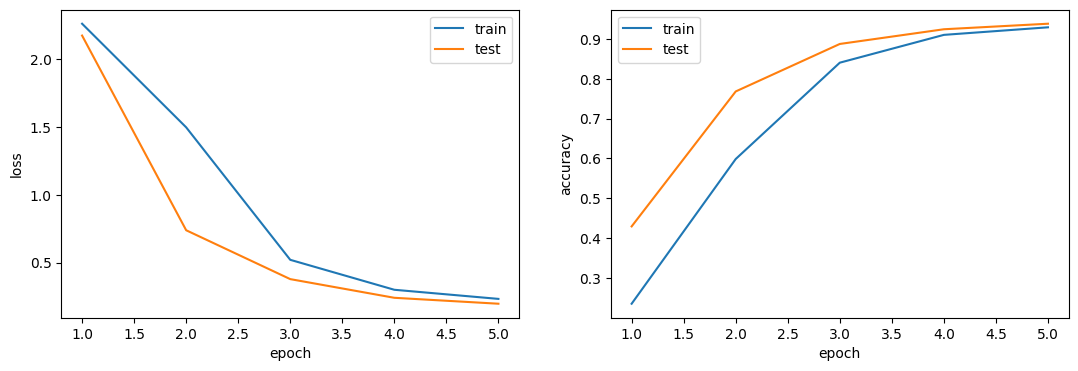

Epoch: 5, loss: 0.19721591498851776, accuracy: 0.9383


In [50]:
train(model_cnn, optimizer, criterion, train_loader, val_loader, NUM_EPOCH)

Посмотрим на ошибки и увидим, что объекты, где наша модель их допускают, более сложные, чем в случае с полносвязной сетью.

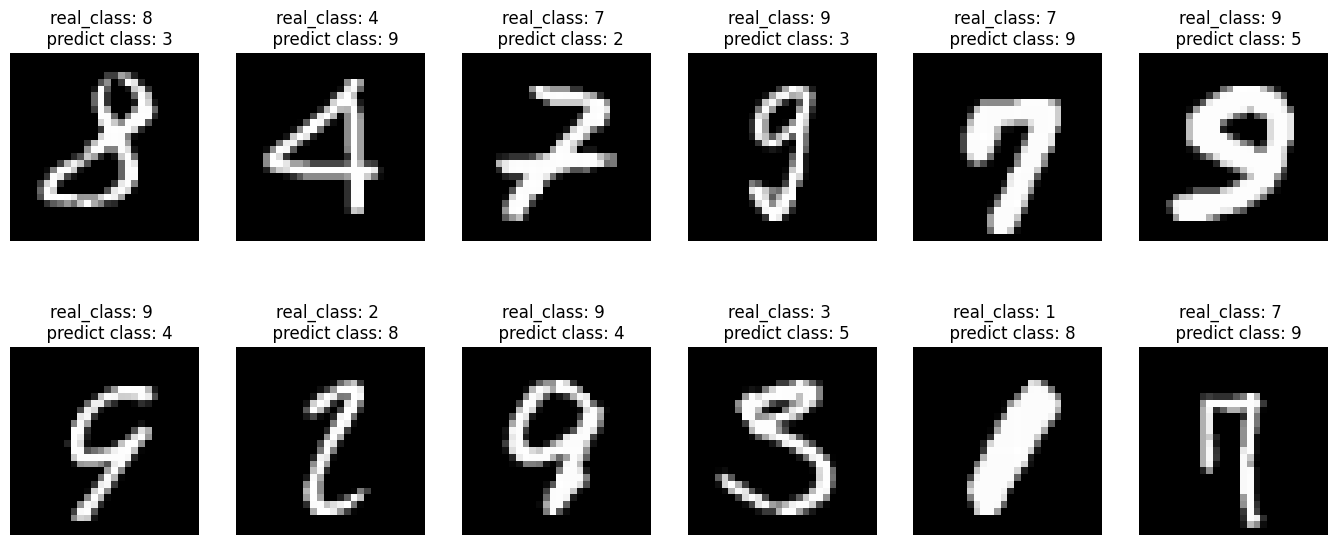

In [51]:
X_test, y_test, y_pred = predict(model_cnn, val_loader)

errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

__Вопрос:__ сколько параметров мы обучаем в свёрточной нейросетке? Меньше ли их, чем в полносвязной? Стали ли результаты лучше?

In [52]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

print("Total number of trainable parameters (FcNet) fully connected NN:", count_parameters(model_fc))
print("Total number of trainable parameters (ConvNet) convolutional NN:", count_parameters(model_cnn))

Total number of trainable parameters (FcNet) fully connected NN: 25818
Total number of trainable parameters (ConvNet) convolutional NN: 6474


# 5. Что такое эмбеддинги

__«Эмбеддинг» (embedding – вложение)__ — это сопоставление произвольной сущности (например, узла в графе, текста или картинки) некоторому вектору.

Нейросетка пытается закодировать в такой вектор всю полезную информацию, которую узнала из выборки, а мы можем этот вектор забрать и использовать для каких-нибудь ещё своих целей. Например, мы можем посчитать эмбеддинги двух картинок и посмотреть, насколько они друг на друга похожи по расстоянию между их векторами.

Один из способов обучить эмбеддинг для картинок — обучить классификатор для какой-то сложной задачи, а затем срезать последние слои. Промежуточный слой будет выдавать вектор какого-то размера для каждой картинки. Эти вектора можно будет использовать в других своих задачах.

Давайте вытащим представление картинок для тестовой выборки с одного из последних слоёв и построим для неё TSNE-визуализацию.

Нам будет довольно просто сделать это для нейронной сети, которую мы выше уже обучили. В ней есть дополнительный метод `get_embedding`, который умеет доставать вектор с последнего свёрточного слоя.

In [55]:
X_emb, y_test = [],[]

for x_batch, y_batch in val_loader:
    x_batch = x_batch.to(device)

    with torch.no_grad():
        X_emb.extend(model_cnn.get_embedding(x_batch).cpu().numpy())
    y_test.extend(y_batch)

In [56]:
X_emb = np.array(X_emb)
y_test = np.array(y_test)

In [57]:
X_emb

array([[ 6.0720778 ,  7.613869  ,  2.1616528 , ...,  3.253485  ,
         7.151563  ,  2.1603794 ],
       [ 6.067481  ,  7.144601  ,  0.8704078 , ...,  6.7208514 ,
        12.274335  , 16.864056  ],
       [ 0.17053044,  3.278894  ,  2.5988128 , ...,  3.3018653 ,
         3.8858733 ,  1.7880545 ],
       ...,
       [ 0.26004648,  1.6032263 ,  2.487292  , ...,  4.0971584 ,
         6.270374  ,  0.        ],
       [ 0.15543212,  1.5834004 ,  7.8381615 , ...,  5.16782   ,
        10.512372  ,  4.501544  ],
       [ 0.14130019,  8.929674  ,  6.5052333 , ...,  7.668934  ,
        17.102888  , 16.500586  ]], dtype=float32)

In [58]:
X_emb.shape # N x emb_size

(10000, 144)

Визуализируем данные с помощью TSNE. Вы знаете этот метод визуализации данных из курса по машинному обучению. Если подзабыли как он работает, почитайте [статью на DistillPub.](https://distill.pub/2016/misread-tsne/) Внутри sklearn есть реализация TSNE.

In [59]:
# можно попробовать более быструю библиотеку с распаралеливанием
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_emb)

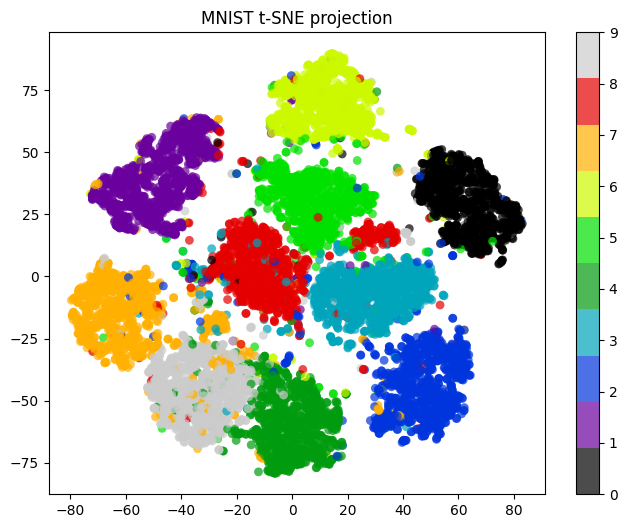

In [60]:
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST t-SNE projection');

Видно, что эмбеддинги впитали в себя информацию о том, к какому классу относится какая картинка. В больших технологических компаниях с картинками часто работают следующим образом.

- Каким-то методом учат огромную нейросеть, которая хорошо понимает что изображено на картинках. Такую большую сетку называют __тушей__ или __тушкой.__
- Берут эмбеддинги с одного из последних слоёв и доучивают на них маленькие модели. Например, модели для классификации. Их называют __головами.__
- Эмбеддинги картинок посылают на вход другим моделям. Например, в градиентный бустинг. Обычно фичи, полученные из нейросети называют __нейросетевыми фичами.__

Конечно же это не единственный способ получать для картинок эмбеддинги. Дальше мы будем обсуждать и другие методы.
